In [76]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import findspark
findspark.init()
import numpy as np

In [2]:
spark=SparkSession.builder.appName('SparkCluster').getOrCreate()

In [9]:
df =  spark.read.csv('seeds_dataset.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length of kernel: double (nullable = true)
 |-- width of kernel: double (nullable = true)
 |-- asymmetry coefficient: double (nullable = true)
 |-- length of kernel groove: double (nullable = true)



In [10]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [11]:
df.columns

['area',
 'perimeter',
 'compactness',
 'length of kernel',
 'width of kernel',
 'asymmetry coefficient',
 'length of kernel groove']

In [12]:
featureAssembler = VectorAssembler(inputCols=['area', 'perimeter','length of kernel'], outputCol='independentFeatures')
df2 = featureAssembler.transform(df)

In [13]:
df3 = df2.select(['area','perimeter','length of kernel','independentFeatures'])

In [50]:
from pyspark.ml.feature import StandardScaler, OneHotEncoder

scaler = StandardScaler().setInputCol('independentFeatures').setOutputCol('scaledFeatures')

In [15]:
scaledModel = scaler.fit(df3).transform(df3)

### Train and Evaluate

In [16]:
kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(scaledModel)

In [17]:
pred = model.transform(scaledModel)

In [18]:
from pyspark.ml.evaluation import ClusteringEvaluator

eval = ClusteringEvaluator()

In [19]:
centers = model.clusterCenters() 
for center in centers:
    print(center)

[ 6.44425095 12.4924826   8.64124309]
[ 5.14055169 11.18463116  7.80398591]
[ 4.15024895 10.19509081  7.05287611]


### Kmeans 2

In [72]:
dt =  spark.read.csv('sales_data.csv', header=True, inferSchema=True)
dt.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Age_Group: string (nullable = true)
 |-- Customer_Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Order_Quantity: integer (nullable = true)
 |-- Unit_Cost: integer (nullable = true)
 |-- Unit_Price: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Cost: integer (nullable = true)
 |-- Revenue: integer (nullable = true)



In [73]:
assemblerDt = VectorAssembler(inputCols=['Unit_Price', 'Profit','Cost','Revenue'], outputCol='Features')
dt2 = assemblerDt.transform(dt)
dt2.show(5,truncate=False)

+-------------------+---+--------+----+------------+--------------+---------------+---------+----------------+----------------+------------+-------------------+--------------+---------+----------+------+----+-------+----------------------------+
|Date               |Day|Month   |Year|Customer_Age|Age_Group     |Customer_Gender|Country  |State           |Product_Category|Sub_Category|Product            |Order_Quantity|Unit_Cost|Unit_Price|Profit|Cost|Revenue|Features                    |
+-------------------+---+--------+----+------------+--------------+---------------+---------+----------------+----------------+------------+-------------------+--------------+---------+----------+------+----+-------+----------------------------+
|2013-11-26 00:00:00|26 |November|2013|19          |Youth (<25)   |M              |Canada   |British Columbia|Accessories     |Bike Racks  |Hitch Rack - 4-Bike|8             |45       |120       |590   |360 |950    |[120.0,590.0,360.0,950.0]   |
|2015-11-26 00:0

In [74]:
dt2 = dt2.select(['Unit_Price', 'Profit','Cost','Revenue','Features'])

In [75]:
scale=StandardScaler(inputCol='Features',outputCol='standardized')
data_scale=scale.fit(dt2)
data_scale_output=data_scale.transform(dt2)
data_scale_output.show(2, truncate=False)

+----------+------+----+-------+-------------------------+------------------------------------------------------------------------------+
|Unit_Price|Profit|Cost|Revenue|Features                 |standardized                                                                  |
+----------+------+----+-------+-------------------------+------------------------------------------------------------------------------+
|120       |590   |360 |950    |[120.0,590.0,360.0,950.0]|[0.1301417910945936,1.2998817416669042,0.40684120772253485,0.7256923576356065]|
|120       |590   |360 |950    |[120.0,590.0,360.0,950.0]|[0.1301417910945936,1.2998817416669042,0.40684120772253485,0.7256923576356065]|
+----------+------+----+-------+-------------------------+------------------------------------------------------------------------------+
only showing top 2 rows



In [77]:
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

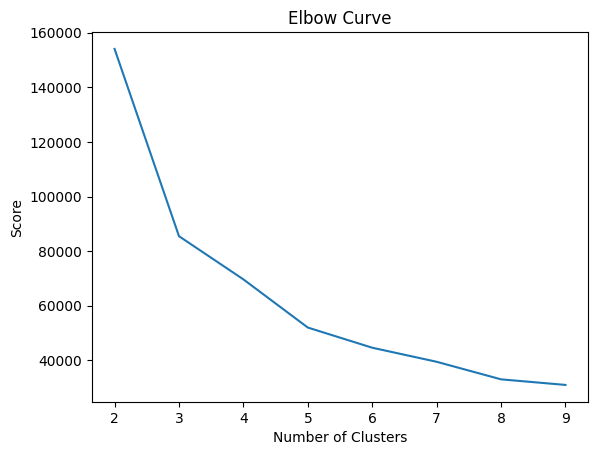

In [78]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [82]:
KMeans_algo=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [83]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+----------+------+----+-------+----------------------------+-------------------------------------------------------------------------------+----------+
|Unit_Price|Profit|Cost|Revenue|Features                    |standardized                                                                   |prediction|
+----------+------+----+-------+----------------------------+-------------------------------------------------------------------------------+----------+
|120       |590   |360 |950    |[120.0,590.0,360.0,950.0]   |[0.1301417910945936,1.2998817416669042,0.40684120772253485,0.7256923576356065] |4         |
|120       |590   |360 |950    |[120.0,590.0,360.0,950.0]   |[0.1301417910945936,1.2998817416669042,0.40684120772253485,0.7256923576356065] |4         |
|120       |1366  |1035|2401   |[120.0,1366.0,1035.0,2401.0]|[0.1301417910945936,3.0095567103677814,1.1696684722022876,1.8340919480874645]  |4         |
|120       |1188  |900 |2088   |[120.0,1188.0,900.0,2088.0] |[0.1301417910945936,2

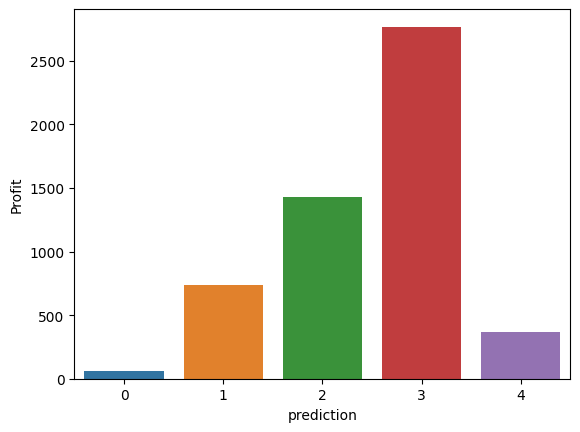

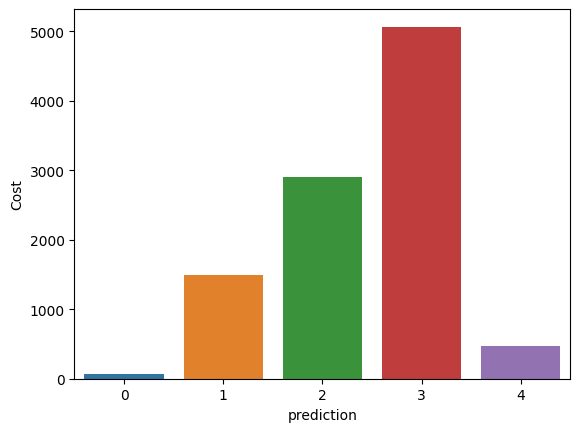

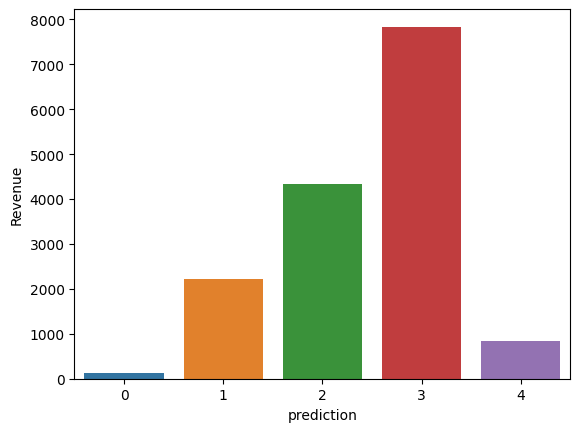

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('Profit','Cost','Revenue','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['Profit','Cost','Revenue']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()